# Running a YOLOv3 or Yolov4 Object Detector with Darknet in the Cloud! (GPU ENABLED)
This tutorial will help you build YOLOv4 or Yolov3 easily in the cloud with GPU enabled so that you can run object detections in milliseconds!

# Step 1: Colab에서 GPU를 세팅한다.
GPU 는 CPU보다 약 100배 정도의 빠른 속도를 가져다 준다.

런타임 > 런타임 유형 변경 > GPU를 설정한다.

# Step 2: Darknet clone 및 설치
AlexeyAB 폴더를 clone 받은 뒤, opencv 와 gpu로 훈련이 가능하도록 설정한다.
이후 darknet을 build한다.

(추후 뜨는 Warning에 대해서는 걱정하지 않아도 된다고 한다!)

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15320, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 15320 (delta 4), reused 3 (delta 3), pack-reused 15315
Receiving objects: 100% (15320/15320), 13.92 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (10373/10373), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

# Step 3: 이들은 시각화를 위한 도구인데, 훈련중에 훈련 이후 결과를 확인하고 싶다면 이 함수를 활용하면 된다!!

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

# Step 4: google drive를 연동한다.
클라우드 상에 데이터를 업로드 한 뒤, 해당 데이터로 훈련하기 위해 클라우드에 접근해야 한다.
또한 obj.names, obj.data, yolov4-tiny-custom.cfg와 같은 데이터를 darknet에서 가져온 뒤, 수정해야 한다. 따라서 다음과 같은 연결 코드가 필요하다!

여기서는 /content/gdrive/Mydrive를 /mydrive로 접근할 수 있는 코드 또한 제공하였다.

In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

 2.MakeCMake_st   4.DeviceControl   images   led       mutex
 3.thread	  Colab_Notebooks   lab      MISRA-C  'My Drive'


In [ ]:
!pwd

/content


In [ ]:

# cd back into the darknet folder to run detections
%cd darknet/

/content/darknet


# Step 5 : 훈련을 위해 다음 파일들을 준비해야 한다.

cfg file의 경우 darknet(https://github.com/AlexeyAB/darknet) 에서 다운 받아 수정한다.
*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt, test.txt file

## 5-1. yolov4, yolov3 형태로 라벨링한다.

yolov4, yolov3 형태란, 다음과 같이 한줄에 한 클래스가 오도록 하는 것이다.


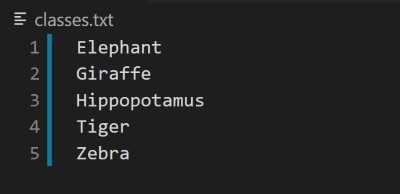

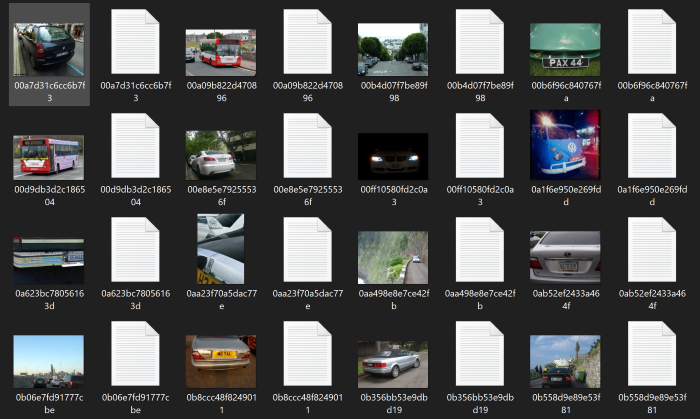


image_name.txt는 다음과 같은 방식으로 저장되어 있다.
<class_id > <x_center> <y_center> <width> <height>

keras에서 yolov3 모델을 전처리했던 방법인 다음과 같이 저장되어 있다면, 
<x_min> <y_min> <x_max> <y_max> <class_id>
convert_annotation.py file을 참고하여 바꾼다. 
(https://github.com/KoYeJoon/yolov4-custom.git)

#### drive에 data 잘있는지 확인해보기!

In [ ]:
# this is where my datasets are stored within my Google Drive (I created a yolov4 folder to store all important files for custom training) 
!ls /mydrive/Colab_Notebooks/yolov4

backup	     data      obj.names  train.txt	     yolov3-tiny.conv.11
classes.txt  obj.data  test.txt   yolo_tiny_prn.cfg


## 5-2. config file 가져오기
이들은 https://github.com/AlexeyAB/darknet 다음 사이트에서 가져올 수 있다. 가져와서 로컬에서 파일을 수정한 뒤, 업로드 해주었다.
- .cfg : config file 
- obj.data : data path 및 back up 할 곳 등의 정보 저장
- obj.names : class name 저장 
- train.txt : train 할 이미지 path들
- test.txt : test 할 이미지 path들

### i) Cfg File
drive에서 가져온다.

In [ ]:
!pwd

/content


In [ ]:
!cp /mydrive/Colab_Notebooks/yolov4/yolov4-tiny-custom.cfg ./cfg

In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/Colab_Notebooks/yolov4/yolo_tiny_prn.cfg ./cfg

## ii) obj.names and obj.data 
**obj.names** 는 class.txt와 같이 작성한다. 


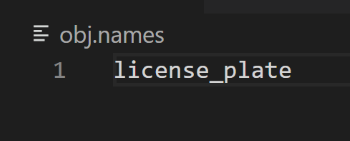

Example for multiclass obj.names file:

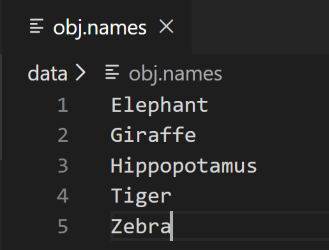

**obj.data** file 은 다음과 같이 작성한다.

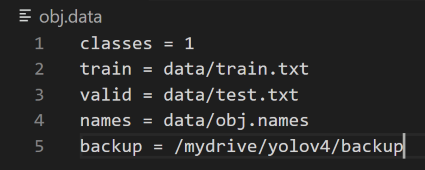

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/Colab_Notebooks/yolov4/obj.names ./data
!cp /mydrive/Colab_Notebooks/yolov4/obj.data  ./data

In [ ]:
!cp /mydrive/Colab_Notebooks/yolov4/train.txt ./data
!cp /mydrive/Colab_Notebooks/yolov4/test.txt ./data

In [ ]:
# verify that the newly generated train.txt and test.txt can be seen in our darknet/data folder
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     test.txt
coco.names  goal.txt	 labels			   openimages.names  train.txt
dog.jpg     horses.jpg	 obj			   person.jpg	     voc.names


train.txt는 다음과 같은 정보가 담겨있다.

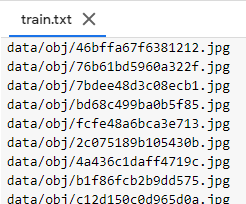

It will contain one line for each training image path.

# Step 6: convolutional layer에 대한 pretrain model을 가져온다.
yolov4-tiny 의 경우 wget으로 가져오면 된다! yolov3-tiny의 경우, yolov3-tiny.conv.11.을 다운받아서 이어서 진행해야 한다.

In [ ]:
!cp /mydrive/Colab_Notebooks/yolov4/yolov3-tiny.conv.11 ./

# Step 7: 훈련을 시작한다.
**TIP:** 구글 코랩에서는 30-90분 동안 활동이 없으면 런타임 연결이 끊어진다. 따라서 다음과 같은 방식을 통해 계속 이벤트를 준다.

개발자 도구의 콘솔에 붙여넣기하면 된다! **Enter**
```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```
이는 10분에 한번씩 클릭하도록 한다!!

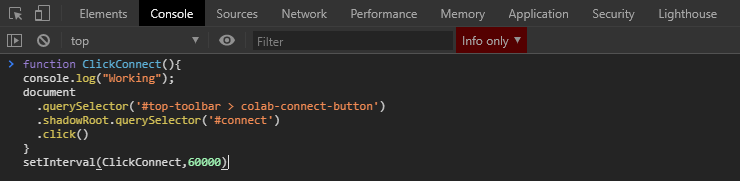

In [ ]:
rm -rf ./data/obj

drive의 data/obj에 저장했던 것들을 darknet의 ./data/obj로 옮겨준다.

In [ ]:
!cp -av /mydrive/Colab_Notebooks/yolov4/data/obj ./data/obj

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
'/mydrive/Colab_Notebooks/yolov4/data/obj/CHESS_COURTYARD_T_B_frame_1816.txt' -> './data/obj/CHESS_COURTYARD_T_B_frame_1816.txt'
'/mydrive/Colab_Notebooks/yolov4/data/obj/CARDS_LIVINGROOM_B_T_frame_2472.txt' -> './data/obj/CARDS_LIVINGROOM_B_T_frame_2472.txt'
'/mydrive/Colab_Notebooks/yolov4/data/obj/JENGA_LIVINGROOM_S_T_frame_1260.txt' -> './data/obj/JENGA_LIVINGROOM_S_T_frame_1260.txt'
'/mydrive/Colab_Notebooks/yolov4/data/obj/PUZZLE_COURTYARD_B_S_frame_0619.txt' -> './data/obj/PUZZLE_COURTYARD_B_S_frame_0619.txt'
'/mydrive/Colab_Notebooks/yolov4/data/obj/JENGA_COURTYARD_H_B_frame_1109.txt' -> './data/obj/JENGA_COURTYARD_H_B_frame_1109.txt'
'/mydrive/Colab_Notebooks/yolov4/data/obj/JENGA_COURTYARD_S_T_frame_0558.txt' -> './data/obj/JENGA_COURTYARD_S_T_frame_0558.txt'
'/mydrive/Colab_Notebooks/yolov4/data/obj/CHESS_LIVINGROOM_H_T_frame_0321.txt' -> './data/obj/CHESS_LIVINGROOM_H_T_frame_0321.txt'
'/mydrive/Colab_Notebooks/yolov4/data/obj/CHESS_OFFIC

In [ ]:
!pwd

/content/darknet


In [ ]:
!./darknet detector train data/obj.data cfg/yolo_tiny_prn.cfg yolov3-tiny.conv.11 -dont_show -map

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Loaded: 0.455064 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 18 Avg (IOU: 0.517740), count: 56, class_loss = 1.189815, iou_loss = 1.991116, total_loss = 3.180931 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 27 Avg (IOU: 0.485956), count: 86, class_loss = 2.491195, iou_loss = 4.144897, total_loss = 6.636092 
 total_bbox = 134817, rewritten_bbox = 0.008901 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 18 Avg (IOU: 0.486478), count: 58, class_loss = 1.597976, iou_loss = 2.481304, total_loss = 4.079279 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 27 Avg (IOU: 0.481873), count: 82, class_loss = 2.411036, iou_loss = 3.902122, total_loss = 6.313158 
 total_bbox = 134957, rewritten_bbox = 0.008892 % 

 (next mAP calculation at 1000 iterations) 
 526: 5.052365, 4.996975 avg loss, 0.000077 rate, 0.627805 seconds, 

After training, you can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you should aim for a loss under 2.

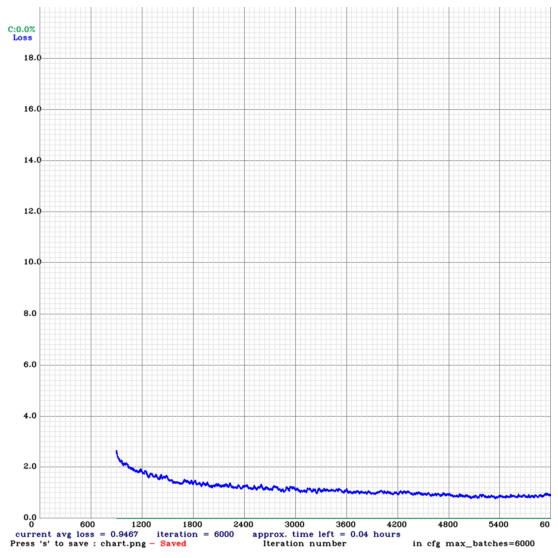

In [ ]:

# show chart.png of how custom object detector did with training
imShow('chart.png')

Here is what the chart.png should look like after an uninterrupted training! If you stop training or it crashes during training your chart will look like the above one but don't worry you can still check accuracy of your model in the next steps.

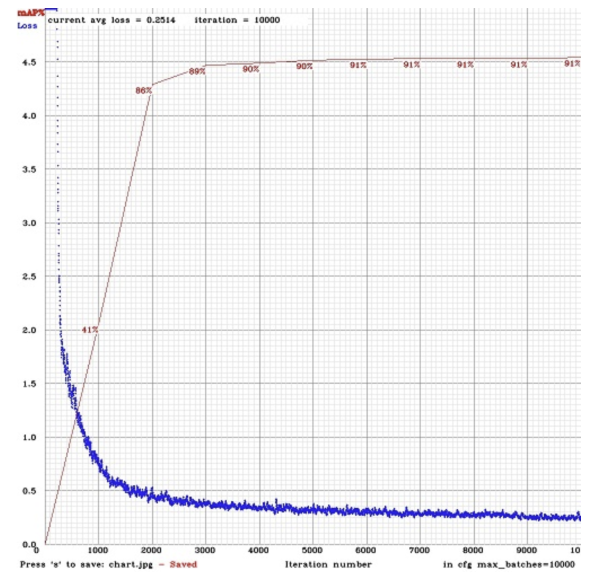

**TRICK**: 중간에 런타임이 끊어지는 경우가 발생할 수 있다. (GPU 할당량 초과 등 ) 그런 경우, yolov4/backup folder에 앞에서 정의했던 .cfg 파일 이름으로 저장된 weight을 불러와서 이어서 학습할 수 있다.  iteration 100번당 한번씩  **{cfg file name}_last.weights** 은 **{obj.data에서 정의한 backup path}* folder 에 저장된다. 


In [ ]:
# kick off training from where it last saved
!./darknet detector train data/obj.data cfg/yolo_tiny_prn.cfg /mydrive/Colab_Notebooks/yolov4/backup/yolo_tiny_prn_last.weights -dont_show

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 total_bbox = 1187704, rewritten_bbox = 0.007325 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 18 Avg (IOU: 0.798504), count: 44, class_loss = 0.304625, iou_loss = 0.199834, total_loss = 0.504459 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 27 Avg (IOU: 0.781471), count: 82, class_loss = 0.821024, iou_loss = 0.524632, total_loss = 1.345656 
 total_bbox = 1187830, rewritten_bbox = 0.007324 % 

 5475: 0.931413, 0.884241 avg loss, 0.000010 rate, 0.627851 seconds, 350400 images, 0.225850 hours left
Loaded: 0.458130 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 18 Avg (IOU: 0.832459), count: 39, class_loss = 0.274825, iou_loss = 0.117207, total_loss = 0.392031 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 27 Avg (IOU: 0.812599), count: 82, class_loss = 0.750831, iou_loss = 0.369135, total_loss = 1.119966 
 total

# Step 8: custom model의 Mean Average Precision (mAP) 를 확인한다.
'-map-' flag를하지 않고 훈련한 경우, mAP를 보고 싶다면 찾을 수 있도록 한다.
저장된 weights 을 통해 mAP 를 비교할 수 있다.

**NOTE:** final weight가 overfitting 되었다고 판단되는 경우 요긴하게 사용될 수 있다.

In [ ]:
!./darknet detector map data/obj.data cfg/yolo_tiny_prn.cfg /mydrive/Colab_Notebooks/yolov4/backup/yolo_tiny_prn_1000.weights

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 2, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128

# Thanks!
Thanks for following along this tutorial, I hope it worked well for all of you!

If you enjoy YOLOv3 or YOLOv4 check out my other videos and subscribe to my channel so you don't miss out on any other amazing YOLO content! 

[The AI Guy](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q)